In [1]:
import os
import sys
import getpass
import math

from omero import model, grid
from omero import rtypes
from omero import ClientError
from omero import sys as om_sys
from omero import constants
from pyomero_upload.pyomero_upload import PyOmeroUploader

from omero.util.script_utils import readFlimImageFile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# configure connection settings
server = 'demo.openmicroscopy.org'
user = 'jhay'
password = getpass.getpass()

········


In [3]:
'''
This cell contains all of the default 'stored procedure' queries in HQL (Hibernate Query
Language) that are used to retrieve various objects from the target remote OMERO server.
Dynamic parameters are defined with the ':*' syntax, where variable values are injected
into the query. For further information, look at the developer documentation at
https://docs.openmicroscopy.org/omero/5.4.10/developers/GettingStarted.html.

You may wish to add further custom queries here by copying and modifying these defaults.
See the OMERO documentation at https://docs.openmicroscopy.org/omero/5.4.10/developers/Model.html,
https://docs.openmicroscopy.org/omero/5.4.10/developers/Model/EveryObject.html and
https://docs.openmicroscopy.org/ome-model/5.6.4/developers/model-overview.html for more information.
'''
# Simply retrieve a dataset by its ID
DATASET_BY_ID_QUERY = "select d from Dataset d where d.id = :did"

# Retrieve datasets by name like
DATASETS_BY_NAME_QUERY = "select d from Dataset d where d.name like :dname"

# Retrieve datasets by associated project ID
DATASETS_BY_PROJECT_QUERY = "select d from Dataset d left outer join fetch d.projectLinks as plinks \
             left outer join fetch plinks.child as dataset where plinks.parent.id = :pid"

# Retrieve images by associated dataset ID
IMAGES_BY_DATASET_QUERY = "select i from Image i left outer join fetch i.datasetLinks as dlinks \
             left outer join fetch dlinks.child as image where dlinks.parent.id = :did"

# Retrieve annotations by associated dataset ID
ANNOS_BY_DATASET_QUERY = "select a from Annotation a where a.id in \
            (select link.child.id from DatasetAnnotationLink link where link.parent.id = :did)"

# Retrieve annotations by associated image ID
ANNOS_BY_IMAGE_QUERY = "select a from Annotation a where a.id in \
            (select link.child.id from ImageAnnotationLink link where link.parent.id = :iid)"

# Find objects by tag text
PROJECTS_BY_TAG_QUERY = "select p from Project p left outer join fetch p.annotationLinks as alinks \
             left outer join fetch alinks.child as annotation where alinks.child.textValue like :anno_text"

DATASETS_BY_TAG_QUERY = "select d from Dataset d left outer join fetch d.annotationLinks as alinks \
             left outer join fetch alinks.child as annotation where alinks.child.textValue like :anno_text"

IMAGES_BY_TAG_QUERY = "select i from Image i left outer join fetch i.annotationLinks as alinks \
             left outer join fetch alinks.child as annotation where alinks.child.textValue like :anno_text"

# Retrieve pixels for images by IDs
PIXELS_BY_IMAGE_QUERY = "SELECT p FROM Pixels as p JOIN FETCH p.image JOIN FETCH p.pixelsType \
             WHERE p.image.id in :iids"

In [4]:
'''
N.B.: Rerun this cell if your connection to the OMERO server has timed-out
'''
uploader = PyOmeroUploader(user, password, server)
searcher = uploader.searcher()

In [6]:
'''
Find child objects using a project ID
'''
params = om_sys.Parameters()
project_id = 1642 ################## Replace this with your own parameter
params.map = {'pid' : rtypes.rlong(project_id)}

datasets = searcher.find_objects_by_query(DATASETS_BY_PROJECT_QUERY, params)

image_id_list = []

for dataset in datasets:
    dataset_id = dataset.id.val
    print(dataset_id)
    params.map = {'did' : rtypes.rlong(dataset_id)}
    images = searcher.find_objects_by_query(IMAGES_BY_DATASET_QUERY, params)
    
    for image in images:
        image_id_list.append(image.id.val)

2928
2929


In [7]:
# retrieve pixels by Image ID
image_id_list = [95279, 111608, 95309, 95323, 95299, 95317] ################## Replace this with your own parameter
image_ids = map(rtypes.rlong, image_id_list)

params = om_sys.Parameters()
params.map = {'iids' : rtypes.rlist(image_ids)}
pixels_list = searcher.find_objects_by_query(PIXELS_BY_IMAGE_QUERY, params)

image_stacks = []

for pixels in pixels_list:
    # see https://github.com/ome/openmicroscopy/blob/v5.4.10/components/tools/OmeroPy/src/omero/util/script_utils.py
    raw_pixels_store = searcher.SESSION.createRawPixelsStore()
    stack = readFlimImageFile(raw_pixels_store, pixels)
    image_stacks.append(stack[0, :, :])

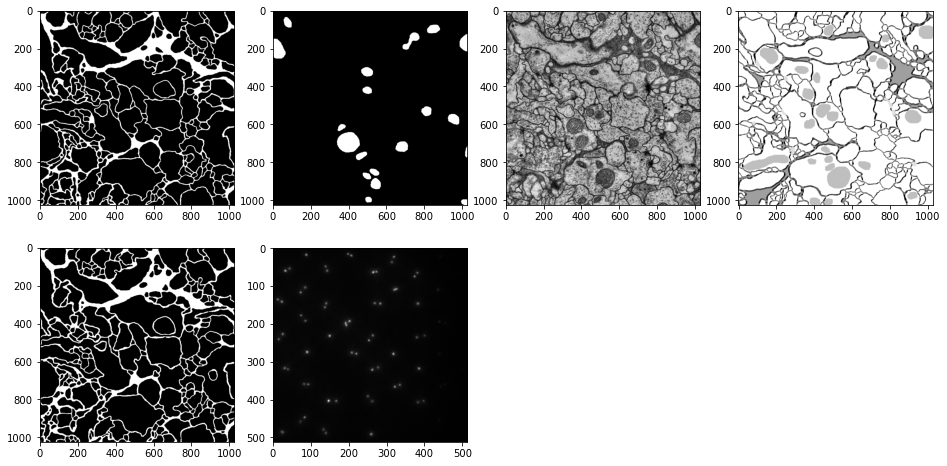

In [8]:
# number of images per row
IMG_COLS_PER_ROW = 4
# create a grid layout to display images with maximum of IMG_COLS_PER_ROW per row
columns = min([len(image_id_list), IMG_COLS_PER_ROW])
rows = int(math.ceil(float(len(image_id_list))/float(columns)))

# create a figure for containing square images with uniform widths and heights
w, h = columns*4, rows*4
fig=plt.figure(figsize=(w,h))

# https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
for idx, image_stack in enumerate(image_stacks):
    pos = idx+1
    fig.add_subplot(rows, columns, pos)
    imgplot = plt.imshow(image_stack, cmap='gray')

plt.show()

In [10]:
'''
Very simple query to find a dataset with a given ID
'''
params = om_sys.Parameters()
dId = 3804 ################## Replace this with your own parameter
params.map = {'did' : rtypes.rlong(dId)}

datasets = searcher.find_objects_by_query(DATASET_BY_ID_QUERY, params)

for dataset in datasets:
    print(dataset.name.val)

Upload from Jupyter2


In [11]:
'''
Simple query to find datasets with names matching the given string (including wildcards)
'''
params = om_sys.Parameters()
dataset_name = "%pload%" ################## Replace this with your own parameter
params.map = {'dname' : rtypes.rstring(dataset_name)}

datasets = searcher.find_objects_by_query(DATASETS_BY_NAME_QUERY, params)

for dataset in datasets:
    print(dataset.id.val)

3801
3804


In [12]:
'''
Run queries to search for objects with tag annotations containing given text
SQL 'Like' queries are achieved with '%' for wildcard characters
'''
params = om_sys.Parameters()
tag_text = "%Bat%" ################## Replace this with your own parameter
params.map = {'anno_text' : rtypes.rstring(tag_text)}

projects = searcher.find_objects_by_query(PROJECTS_BY_TAG_QUERY, params)
datasets = searcher.find_objects_by_query(DATASETS_BY_TAG_QUERY, params)
images = searcher.find_objects_by_query(IMAGES_BY_TAG_QUERY, params)

In [13]:
for project in projects:
    print(project.name.val)

for dataset in datasets:
    print(dataset.name.val)

for anno in dataset.linkedAnnotationList():
    print(anno.textValue.val)

for image in images:
    print(image.name.val)

Johnny Test Project
upload_test
Upload from Jupyter2
test_dataset
test_dataset
Batgirl
pos001


In [14]:
'''
Fetch all annotations for a dataset given ID

This cell can be modified to retrieve annotations for individual images by altering the params.map
with the selected image_id and 'iid' parameter name, and by using the ANNOS_BY_IMAGE_QUERY in the
call to the searcher function.
'''
params = om_sys.Parameters()
dataset_id = 3804 ################## Replace this with your own parameter
params.map = {'did' : rtypes.rlong(dataset_id)}

anno_list = searcher.find_objects_by_query(ANNOS_BY_DATASET_QUERY, params)
tags = []
kvp_dict = dict()
file_anno_ids = []

for anno in anno_list:
    if isinstance(anno, model.TagAnnotationI):
        tags.append(anno.textValue.val)
    elif isinstance(anno, model.MapAnnotationI):
        mapAnno = anno.mapValue
        
        for kvp in mapAnno:
            if isinstance(kvp, model.NamedValue):
                kvp_dict[kvp.name] = kvp.value
    elif isinstance(anno, model.FileAnnotationI):
        file_anno_ids.append(anno.id.val)

print(tags)
print(kvp_dict)
print(file_anno_ids)

['28-Sep-2018', 'Batgirl']
{'Brightfield': '[\'"White LED;->(polarizer + prism + condenser)"]\']', '->Filter block': '[\'["59022 exciter, 59022 dichroic, 535/50 emission filter]\']', '->Emission filter wheel': "['[]']", 'DIC': '[\'"White LED;->(polarizer + prism + condenser)"]\']', 'GFP': '[\'"470nm LED\']', '->Combiner cube': '[\'[ No exciter in combiner cube,  495lp dichroic-> (425lp dichroic)"]\']', 'Micromanager config file': "['C']", 'Strain': "[['Htb2-GFP', 'Myo1-GFP', 'Hog1-GFP', 'Lte1-GFP', 'Vph1-GFP']]", 'Project': "['Morphology detection']", 'Experiment Start Date': "['28-Sep-2018 17:18:14']"}
[6708, 6706, 6709, 6707]
